# Segmentación de imagen con CAMVID 

En este notebook vamos a entrenar un modelo que será capaz de segmentar una imagen, píxel a píxel, distinguiendo entre distintas clases (coche, peatón, ciclista, etc.).

Con los siguientes [*magic commands*](https://ipython.readthedocs.io/en/stable/interactive/magics.html/) nos aseguramos de recargar de forma automática cualquier modificación de las librerías o de los gráficos.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Cargamos las imágenes

Desde FastAi importamos el módulo *vision* para la gestión de imágenes, el módulo *callbacks.hooks* como una extensión de registro del modelo y el módulo *utils.mem* para acceder a los recursos de la memoria RAM.

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

Con la función 'untar_data' accedemos al dataset CAMVID a través de una URL. En la variable 'path' asignamos la ruta de acceso a dicho dataset.

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/storage/camvid/images'),
 PosixPath('/storage/camvid/labels'),
 PosixPath('/storage/camvid/valid.txt'),
 PosixPath('/storage/camvid/codes.txt')]

En la variable 'path_lbl' creamos el directorio para las etiquetas. Y en la variable 'path_img' el directorio para las imágenes. 

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

En la variable 'fnames' asignamos las imágenes con la función 'get_image_files', mostramos las 3 primeras.

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/storage/camvid/images/Seq05VD_f04020.png'),
 PosixPath('/storage/camvid/images/0016E5_08129.png'),
 PosixPath('/storage/camvid/images/0001TP_009660.png')]

En la variable 'lbl_names' asignamos las imágenes etiquetadas con la función 'get_image_files', y mostramos las 3 primeras.

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/storage/camvid/labels/0016E5_07170_P.png'),
 PosixPath('/storage/camvid/labels/0001TP_009930_P.png'),
 PosixPath('/storage/camvid/labels/0016E5_04920_P.png')]

En la variable 'img' asignamos la primera imagen de 'fnames' y la mostramos con un tamaño de figura ('figsize') de 5 x 5.

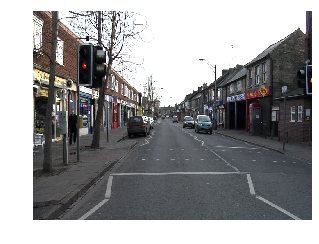

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5, 5))

En la 'get_y_fn' creamos una función anónima ('[lambda](https://docs.hektorprofe.net/python/funcionalidades-avanzadas/funciones-lambda/)') para obtener, a partir del nombre del archivo de imagen, la etiqueta con '[x.stem](https://docs.python.org/3/library/pathlib.html)' y la extensión de cada archivo con '[x.suffix](https://docs.python.org/3/library/pathlib.html)', que será el nombre del archivo máscara.

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

En 'mask' creamos la máscara segmentada de una imagen con la función 'open_mask'. Y la mostramos con la función 'show'.

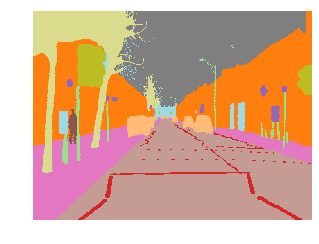

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

En 'src_size' creamos una *array* con la función 'array' de la librería 'Numpy' con el tamaño de la máscara. Mostramos 'src_size' y con la función 'data' mostramos el tensor de la máscara con la segemtación de la imagen por píxeles. 

In [10]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

En 'codes' creamos una lista con la codificación de cada elemento que puede aparecer en una imagen. Con la función 'loadtxt' de Numpy (np) obtenemos los códigos desde el archivo 'code.txt'.

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Creamos los conjuntos de datos para el entrenamiento

En esta celda vamos a crear la variable 'size', donde asignaremos el entero de dividir 'src_size' entre 2, y limitaremos el 'batch size' (tamaño de lote) en función de la memoria disponible, que obtendremos con la función 'gpu_mem_get_free_no_cache' de la librería 'fastai.utils.mem'.

In [12]:
size = src_size//2
free = gpu_mem_get_free_no_cache()
if free > 8200: bs = 8
else:           bs = 4
print(f'usando bs={bs} tenemos {free}MB de GPU RAM libres')

usando bs=4 tenemos 8114MB de GPU RAM libres


Con la función 'SegmentationItemList.from_folder' creamos una lista de las imágenes con sus respectivas máscaras aignadas desde el directorio 'path_img'. Dividimos el conjunto de datos con la función 'split_by_fname_file' desde el archivo 'valid.txt', para obtener el *validation set*. Con la función 'label_from_func' obtenemos una lista de las etiquetas ejecutando la función 'get_y_fn' pasándole la lista de etiquetas almacenadas en la variable 'codes'.

In [13]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

En 'data' creamos el 'databunch' de las imágenes. Primero realizamos las tranformaciones oportunas con 'get_transforms()', establecemos el tamaño de las imágenes con el dato de la variable 'size'. Para aplicar las mismas transformaciones tanto en la imagen como en la máscara cambiamos el valor de 'tfm_y' a 'True'.

A la función 'databunch' le pasamos el *batch size* (bs) de 4 o de 8 según la memoría libre disponible. Con 'normalize' normalizamos las transformaciones con los datos de 'imagenet_stats'.

In [14]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

Con la función 'show_batch' mostramos un lote de cuatro imágenes (matriz de 2 x 2) de tamaño 10 x 7. Por defecto se muestran imágenes del *train set*.

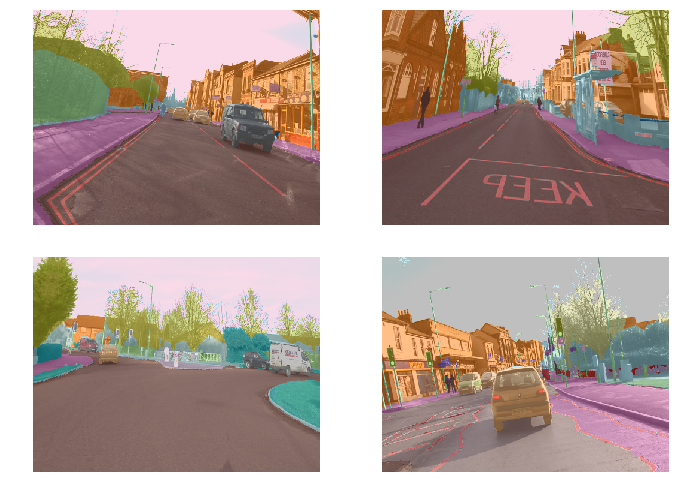

In [15]:
data.show_batch(2, figsize=(10, 7))

En la siguiente celda haremos lo mismo pero con imágenes del *validation set*.

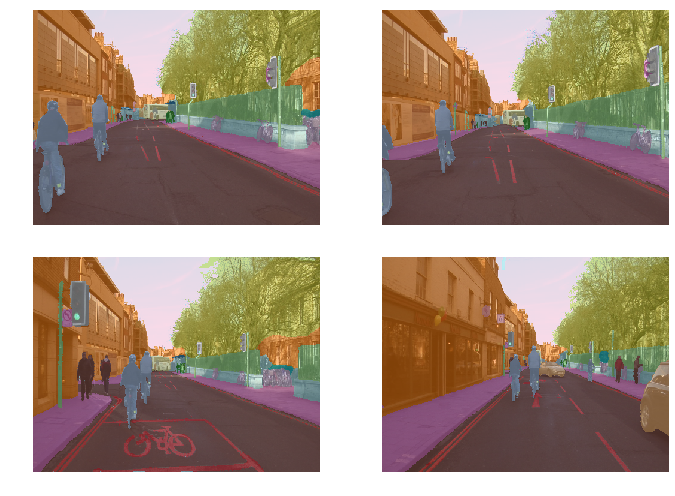

In [16]:
data.show_batch(2, figsize=(10, 7), ds_type=DatasetType.Valid)

## Creamos nuestro Modelo

En la siguiente celda vamos a crear una métrica nueva para evaluar el rendimiento de nuestro modelo. Primero creamos un diccionario en 'name2id' iterando sobre un *loop for* con el píxel y su etiqueta. Identíficamos la variable 'void_code' con los posibles píxeles etiquetados como 'Void' (vacío).

Definimos la función 'acc_camvid' que nos devolverá un número tipo *float* que será el resultado de pasar el valor de 'input'a la función 'argmax'.

In [17]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
  target = target.squeeze(1)
  mask = target != void_code
  return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

En 'metrics' asignamos nuestra métrica 'aac_camvid'. 

In [18]:
metrics = acc_camvid

En 'wd' establecemos un *weigth decay* de 0.01.

In [19]:
wd = 1e-2

Creamos nuestro modelo en 'learn'. En este caso será una 'unet_learner', y le pasamos los datos en 'data', la arquitectura (resnet34), 'metrics' y 'wd'.

In [20]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

En primer lugar averiguamos cual es el *learning rate* del modelo con 'lr_find' y lo graficamos con 'recorder.plot()'.

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


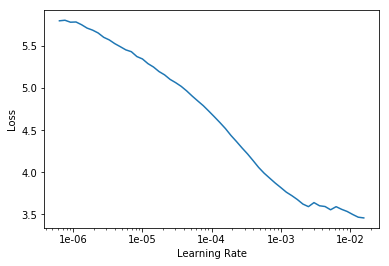

In [21]:
lr_find(learn)
learn.recorder.plot()

En 'lr' seleccionamos un *learning rate* de 0.003.

In [22]:
lr=3e-3

Entrenamos nuestro modelo en 10 épocas y le pasamos 'lr' y un 'pct_start' de 0,9 para que el 'lr' no se incremente durante todo el entrenamiento y decrezca un 0,1.

In [23]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.977930,0.748006,0.827670,02:36
1,0.733757,0.664580,0.833455,02:30
2,0.647328,0.598623,0.858918,02:30
3,0.642805,0.531781,0.868600,02:30
4,0.623272,0.522175,0.862193,02:30
5,0.615895,0.478395,0.873000,02:30
6,0.567027,0.591560,0.847842,02:30
7,0.535237,0.444615,0.873667,02:30
8,0.478294,0.416513,0.882441,02:30
9,0.420389,0.325373,0.899006,02:30


Obtenemos una 'acc_camvid' 0.899006. Guardamos en 'stage-1'. 

In [24]:
learn.save('stage-1')

Cargamos de nuevo el modelo.

In [25]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /storage/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /storage/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

Mostramos los resultados con 'show_results'. 

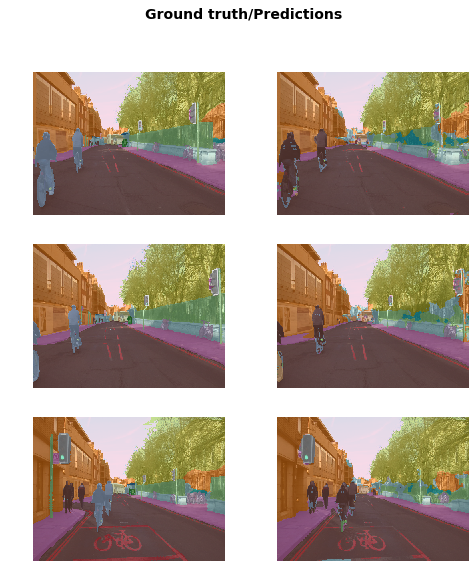

In [26]:
learn.show_results(rows=3, figsize=(8, 9))

Una vez nuestro modelo termina la última época de entrenemiento, "unet_learner" congela (*freeze*) los pesos (*weights*) obtenidos en cada capa para evitar perder, por accidente, el rendimeiento conseguido hasta el momento. Para poder reentrenar el modelo partiendo desde los últimos pesos, debemos descongelarlo (*unfreeze*).

In [27]:
learn.unfreeze()

Vamos a probar un *learning rate* diferente.

In [28]:
lrs = slice(lr/400, lr/4)

Entrenamos de nuevo durante 12 épocas con el nuevo 'lr' y probamos un 'pct_start' de 0.8.

In [29]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.362288,0.320746,0.900603,02:39
1,0.364486,0.316340,0.903975,02:39
2,0.352855,0.301908,0.909552,02:39
3,0.338492,0.296365,0.912328,02:39
4,0.345979,0.292084,0.911971,02:39
5,0.326140,0.300048,0.913938,02:39
6,0.328799,0.315046,0.907571,02:39
7,0.323797,0.309624,0.910332,02:39
8,0.310109,0.281452,0.918269,02:39
9,0.293188,0.292142,0.912799,02:39


Conseguimos una 'acc_camvid' de 0.925776. Guardamos en 'stage-2'.

In [30]:
learn.save('stage-2')

## Nuevo Modelo

Vamos a empezar de nuevo con el tamaño de imagen original. Destruimos el modelo y empezamos limitando el tamaño de 'bs' en función de la memoria disponible.

In [31]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
if free > 8200: bs = 3
else:           bs = 1
print(f'usando bs={bs} tenemos {free}MB de GPU RAM libres')

this Learner object self-destroyed - it still exists, but no longer usable
usando bs=1 tenemos 7717MB de GPU RAM libres


Creamos nuestra variable 'data' con el nuevo tamaño ('size').

In [33]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

Creamos de nuevo el modelo 'learn'.

In [34]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Cargamos los pesos del último entrenamiento guardados en 'stage-2'.

In [35]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /storage/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /storage/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

Buscamos el nuevo *learning rate* y lo graficamos.

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


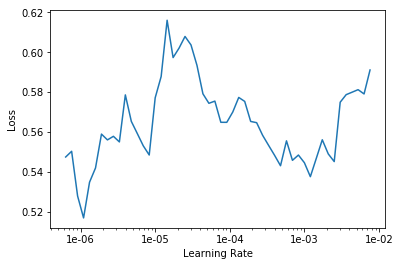

In [36]:
lr_find(learn)
learn.recorder.plot()

Establecemos un 'lr' de 0.001.

In [37]:
lr = 1e-3

Entrenamos el nuevo modelo en 10 épocas y le pasamos 'lr' y pct_start.

In [39]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.427131,0.320634,0.911330,10:14
1,0.374231,0.308147,0.913056,10:14
2,0.363740,0.338895,0.915076,10:14
3,0.353268,0.302523,0.915022,10:14
4,0.332570,0.365005,0.908761,10:14
5,0.352837,0.334814,0.919740,10:14
6,0.377967,0.289846,0.920559,10:14
7,0.376757,0.334943,0.906336,10:13
8,0.279742,0.280094,0.927891,10:13
9,0.233745,0.265844,0.927090,10:14


Obtenemos una 'acc_camvid' de 0.927090. Guardamos en 'stage-1-big'.

In [40]:
learn.save('stage-1-big')

Cargamos.

In [41]:
learn.load('stage-1-big')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /storage/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /storage/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

Descongelamos el modelo antes de entrenar de nuevo durante 10 épocas con un nuevo 'lrs'.

In [42]:
learn.unfreeze()

In [43]:
lrs = slice(1e-6, lr/10)

In [44]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.228825,0.270708,0.927204,10:50
1,0.231561,0.275486,0.925453,10:49
2,0.232362,0.255135,0.929785,10:50
3,0.225752,0.244244,0.933217,10:49
4,0.217876,0.250551,0.932401,10:49
5,0.204198,0.250704,0.931563,10:50
6,0.208177,0.257464,0.930910,10:50
7,0.201383,0.252169,0.933505,10:49
8,0.207465,0.243142,0.935572,10:50
9,0.194103,0.249992,0.933460,10:50


Alcanzamos una 'acc_camvid' de 0.933460. Guardamos en 'stage-2-big' y cargamos para mostrar resultados.

In [45]:
learn.save('stage-2-big')

In [46]:
learn.load('stage-2-big')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /storage/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /storage/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

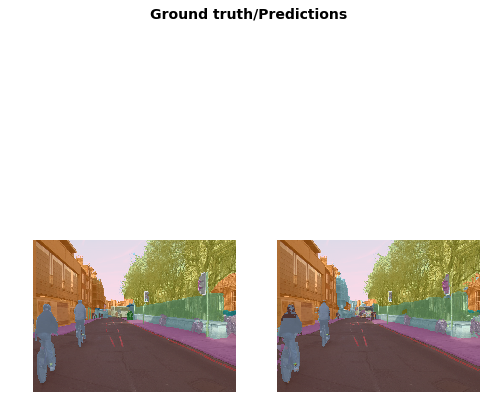

In [48]:
learn.show_results(rows=3, figsize=(8, 9))

# Conclusión.

Nuestro modelo está listo para realizar la segmentación de imágenes con un rendimiento más que aceptable.